In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.tree import export_text, plot_tree
from sklearn.tree import export_graphviz
# from graphviz import Source,Digraph|
import networkx as nx
from networkx import DiGraph
from sklearn.tree import DecisionTreeClassifier

In [2]:
class Generator():
    def __init__(self, n_stages=6,  n_ways=4, size=100):
        self.df = None        
        self.n_stages = n_stages
        self.n_ways = n_ways
        self.size = size
    
    def make_df(self):
        df_len = self.n_ways * self.size
        data = pd.DataFrame(np.arange(df_len), columns=['id'])
        data['stages'] = [0] * df_len
        ways = []
       
        # creating random ways
        while len(ways) != self.n_ways:
            way = [1] # start
            way_len = np.random.randint(2, self.n_stages)
            for _ in range(way_len):
                stage = np.random.randint(2, self.n_stages)
                way.append(stage)
            way.append(self.n_stages)
            way = pd.unique(way).tolist()
            if way not in ways and len(way) > 2:
                ways.append(way)                
        ways = np.repeat(ways, self.size)
        data['stages'] = ways            
        self.df = data
        return self    
    
    def make_features(self):
        data = self.df
        data = data.explode('stages')
        data['stages'] = data['stages'].astype(str)
        data['from'] = data.groupby(['id'])['stages'].shift(1)          
        edges = data.loc[:, ['from', "stages"]].drop_duplicates().dropna().values
        edges = [list(map(str, edge)) for edge in edges]                
        feature_cols = []
        i = 0
        for stage in data['stages'].unique():               
            transitions = list(filter(lambda x: stage in x[0], edges))
            if len(transitions) > 1:                
                stage_from = stage
                stages_to = [transition[1] for transition in transitions]

                train_mask = data['from'] == stage_from

                feat_name = 'X_{}'.format(i)
                for feat, stage_to in enumerate(stages_to):
                    mask = (data["stages"] == stage_to) & (data['from'] == stage_from)
                    data.loc[mask, feat_name] = (feat + 1) 
                    data.loc[mask, feat_name] += 1.1 * np.random.random(data.loc[mask, feat_name].shape[0]) - 0.55
                feature_cols.append(feat_name)
            i += 1
        data[data.columns[3:]] = data[data.columns[3:]].fillna(0)
        self.df = data
        return feature_cols, data        

In [3]:
G = Generator()
G.make_df()
G.df.head()

,id,stages
0,0,"[1, 4, 5, 2, 6]"
1,1,"[1, 4, 5, 2, 6]"
2,2,"[1, 4, 5, 2, 6]"
3,3,"[1, 4, 5, 2, 6]"
4,4,"[1, 4, 5, 2, 6]"


In [4]:
feature_cols, data = G.make_features()
data.head()

,id,stages,from,X_0,X_1,X_2,X_3
0,0,1,NaN,0.000000,0.000000,0.000000,0.000000
0,0,4,1,0.835677,0.000000,0.000000,0.000000
0,0,5,4,0.000000,1.093449,0.000000,0.000000
0,0,2,5,0.000000,0.000000,0.589664,0.000000
0,0,6,2,0.000000,0.000000,0.000000,1.518951


### implementing Graph class

In [155]:
class Graph():
    def __init__(self, df, id_col, stage_col):
        self.df = df
        self.id_col = id_col
        self.stage_col = stage_col
#         self.feature_cols = feature_cols
        self.stages = np.unique(self.df[stage_col])
        self.graph = None
        
    def create_graph(self):
        stages = self.df[self.stage_col].unique()
        graph = DiGraph() #(comment='Process', format = 'pdf')
        for stage in stages:
            graph.add_node(str(stage))
        self.df['from'] = self.df.groupby([self.id_col])[self.stage_col].shift(1)
        edges = self.df.loc[:, ['from', self.stage_col]].drop_duplicates().dropna().values
        edges = [list(map(str, edge)) for edge in edges]
        graph.add_edges_from(edges)
        self.graph = graph
        return graph
    
    def draw_connections(self):

        activity_matrix = np.zeros((len(self.stages)+1, len(self.stages)+1))
        
        for _, row in self.df.iterrows():
            if(pd.isna(row['from'])):
                continue
            else:
                x_from = int(row['from'])
                x_stag = int(row['stages'])
                activity_matrix[x_from, x_stag] += 1

        self.activity_matrix = activity_matrix
        
        graph = DiGraph()
        graph.add_nodes_from(self.graph.nodes)
        
        plt.figure(figsize=(16, 8))
        for edge in self.graph.edges:
            graph.add_edge(edge[0], edge[1], weight=1 + 0.03*activity_matrix[int(edge[0]), int(edge[1])])
            
        weights = [graph[u][v]['weight'] for u,v in graph.edges]
        nx.draw(graph, width=weights, with_labels=True, font_size=20, node_size=1000, node_color='c')
        plt.show()
        
    def draw_activities(self):
        
        activities = []
        for edge in self.graph.edges:
            activities.append(str(edge[0]) + '-' + str(edge[1]))
            
        activity_matrix = np.zeros((len(activities), len(activities)))
        act_dict = dict()
        for i,act in enumerate(activities):
            print(act)
            act_dict = 0
        for _, row in self.df.iterrows():
            act = str(row['from']) + '-' + str(row['stages'])
            act_dict[act] += 1

In [156]:
d = dict()
d['a'] = 1

In [157]:
G = Graph(data, 'id', 'stages')
G.create_graph()
G.draw_activities()

1-4
1-2
4-5
4-2
5-2
5-6
2-6
2-5
2-4
2-3
3-6


TypeError: 'int' object is not subscriptable

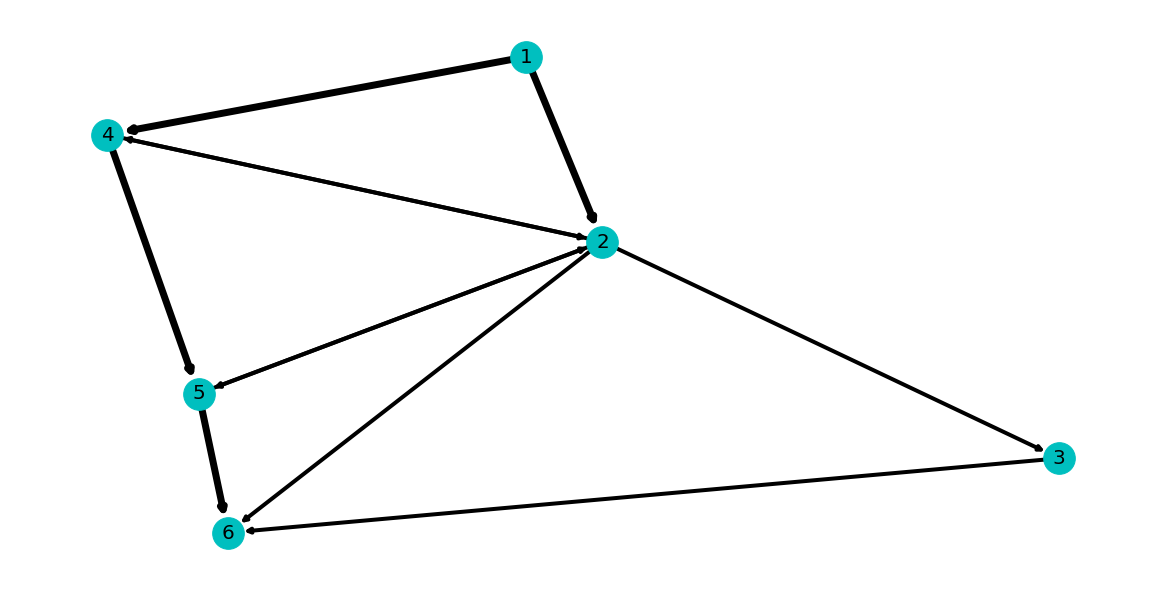

In [138]:
G = Graph(data, 'id', 'stages')
G.create_graph()
G.draw_connections()

In [119]:
np.isnan('1')

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### implementing RuleFinder

In [40]:
class RuleFinder():
    def __init__(self, df, id_col, stage_col, feature_cols):
        self.df = df
        self.id_col = id_col
        self.stage_col = stage_col
        self.feature_cols = feature_cols
        self.graph = None
        
    def create_graph(self):
        stages = self.df[self.stage_col].unique()
        graph = DiGraph() #(comment='Process', format = 'pdf')
        for stage in stages:
            graph.add_node(str(stage))
        self.df['from'] = self.df.groupby([self.id_col])[self.stage_col].shift(1)
        edges = self.df.loc[:, ['from', self.stage_col]].drop_duplicates().dropna().values
        edges = [list(map(str, edge)) for edge in edges]
        graph.add_edges_from(edges)
        self.graph = graph
        return graph

    def _save_dot(self, trees):
        for num, tree in trees.items():
            if tree != None:
#                 export_graphviz(trees[num], out_file='tree{}.dot'.format(num),
#                     feature_names=self.feature_cols,node_ids=True)
                export_text(trees[num], out_file='tree{}.txt'.format(num),
                    feature_names=self.feature_cols, node_ids=True
                            
                            
#probably not needed
                            
#     def _make_features(self):
#         feature_cols = []
#         i = 0
#         for stage in self.df[self.stage_col].unique():
#             transitions_str = list(filter(lambda x: '\t{} -> '.format(stage) in x, self.graph.body))
#             if len(transitions_str) > 1:
#                 feature_cols.append('X_{}'.format(i))
#                 self.df['X_{}'.format(i)] = np.zeros(shape=self.df.shape[0])
                
#                 transitions = list(map(lambda x: x.strip().split(" -> "), transitions_str))

#                 stage_from = stage
#                 stages_to = [transition[1] for transition in transitions]

#                 train_mask = self.df['from'] == stage_from

#                 for feat, stage_to in enumerate(stages_to):
#                     mask = (self.df[self.stage_col] == stage_to) & (self.df['from'] == stage_from)
#                     self.df.loc[mask, 'X_{}'.format(i)] = feat + 1
#                     self.df.loc[mask, 'X_{}'.format(i)] += 1.5*np.random.random(
#                         self.df.loc[mask, 'X_{}'.format(i)].shape[0]) -0.75
#                 i += 1
#         self.feature_cols = feature_cols
#         return self.df  
                            
    def compute_trees(self,min_impurity_decrease = 0.0015):
        trees = {}
        for stage in self.df[self.stage_col].unique():
            transitions_str = list(filter(lambda x: '\t{} -> '.format(stage) in x, self.graph.body))
            if len(transitions_str) > 1:
                transitions = list(map(lambda x: x.strip().split(" -> "), transitions_str))

                stage_from = stage
                stages_to = [transition[1] for transition in transitions]

                train_mask = self.df['from'] == stage_from

                for stage_to in stages_to:
                    mask = (self.df[self.stage_col] == stage_to) & (self.df['from'] == stage_from)
                    self.df.loc[mask, '_target_'] = stage_to

                X = self.df.loc[train_mask, self.feature_cols].values
                y = self.df.loc[train_mask, '_target_']
                
                min_class_ratio = 0.3 * np.min(y.value_counts()) / y.shape[0]
                tree = DecisionTreeClassifier(
                    min_samples_leaf=min_class_ratio, 
                    min_impurity_split=0.2, 
                    min_impurity_decrease=min_impurity_decrease)
                tree.fit(X, y)
                
                trees[stage] = tree
            else:
                trees[stage] = None
        self.df.drop('_target_', inplace=True, axis=1)
        
        self._save_dot(trees)
        return trees

In [41]:
F = RuleFinder(data, 'id', 'stages', feature_cols)

In [42]:
graph = F.create_graph()

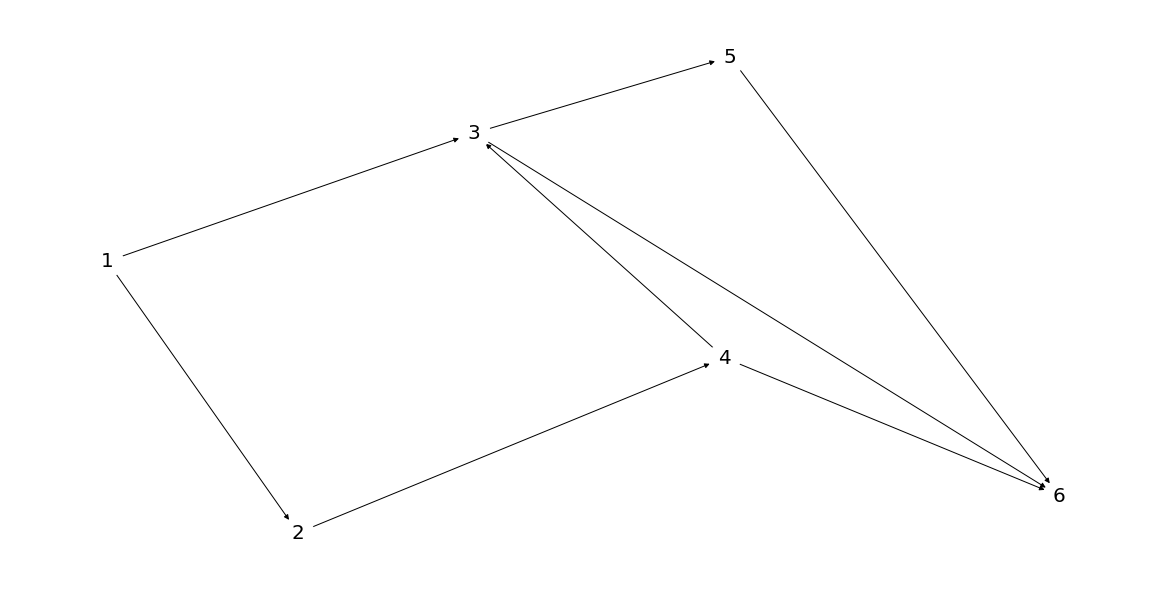

In [60]:
plt.figure(figsize=(16, 8))
nx.draw(graph, with_labels=True, font_size=20, node_size=1000, node_color='w')
plt.show()

In [69]:
print(graph.nodes)
print(graph.edges)

['1', '2', '4', '6', '3', '5']
[('1', '2'), ('1', '3'), ('2', '4'), ('4', '6'), ('4', '3'), ('3', '5'), ('3', '6'), ('5', '6')]


In [65]:
#graph.body == 
['\t1',
 '\t2',
 '\t5',
 '\t4',
 '\t6',
 '\t3',
 '\t1 -> 2',
 '\t2 -> 5',
 '\t5 -> 4',
 '\t4 -> 6',
 '\t2 -> 4',
 '\t1 -> 3',
 '\t3 -> 5',
 '\t5 -> 2',
 '\t2 -> 6',
 '\t1 -> 4',
 '\t4 -> 2']

['\t1',
 '\t2',
 '\t5',
 '\t4',
 '\t6',
 '\t3',
 '\t1 -> 2',
 '\t2 -> 5',
 '\t5 -> 4',
 '\t4 -> 6',
 '\t2 -> 4',
 '\t1 -> 3',
 '\t3 -> 5',
 '\t5 -> 2',
 '\t2 -> 6',
 '\t1 -> 4',
 '\t4 -> 2']